## Analyze individual-level multimodal topographic connectivity

In [ ]:
%load_ext autoreload
%autoreload 2

from vicsompy.aggregate import Aggregator
from mne.stats.cluster_level import _find_clusters, _setup_adjacency
from vicsompy.surface import Subsurface
from vicsompy.subject import HcpSubject
from vicsompy.modeling import MssCf
from vicsompy.surface import CiftiHandler
mch=CiftiHandler()
import cortex
import numpy as np
from scipy import stats
from scipy.stats import binom
from operator import itemgetter
from tqdm import tqdm
from vicsompy.vis import Plot
from vicsompy.utils import load_pkg_yaml, load_plot_pkg_yaml
import os
from scipy.stats import t as tdist
from vicsompy.vis import basic_plot
import pandas as pd
from vicsompy.utils import Unpick
from vicsompy.utils import MmpMasker
from sklearn import mixture
import matplotlib.pyplot as plt
mm=MmpMasker()

plotviews=load_plot_pkg_yaml()['plotviews']
vertsperhem=59292

Load in the movie data

In [10]:
myagg_mov = Aggregator(expt_id='movie', analysis_name='TEST', agg_name='newagg')  # Create an instance of the Aggregator class for the 'movie' experiment with analysis name 'TEST' and aggregator name 'newagg'
myagg_mov.load_all_sub_frames(myagg_mov.all_subjects)  

Load in the V1 source region and make an S1 mask.

In [13]:
with open('/tank/hedger/scripts/Sensorium/data/surfaces/visual_subsurface.pickle', 'rb') as handle:
    surf=(Unpick(handle).load())

msk=mm.make_roi_mask('3b')

Get the variance explained scores for both modalities.

In [14]:
vexpl_som=np.array([frame['train_scores_somato_score'] for frame in myagg_mov.frames])
vexpl_vis=np.array([frame['train_scores_visual_score'] for frame in myagg_mov.frames])

In [25]:
topsom=np.array([frame['test_scores_somato_score']-frame['null_score_somato'] for frame in myagg_mov.frames])
topvis=np.array([frame['test_scores_visual_score']-frame['null_score_visual'] for frame in myagg_mov.frames])
t_som, p_value_som = stats.ttest_1samp(topsom, popmean=0) 
t_vis, p_value_vis = stats.ttest_1samp(topvis, popmean=0) 

In [24]:
somt=np.save(os.path.join(load_pkg_yaml()['paths']['plot_out'],'somt.npy'),t_som)
vist=np.save(os.path.join(load_pkg_yaml()['paths']['plot_out'],'vist.npy'),t_vis)

Ensure appropriately masked by taking out the source regions.

In [15]:
masksom=[]
masks1=[]
maskv1=[]
from tqdm import tqdm
for count,v in tqdm(enumerate(vexpl_som)):
    s,c=mch.decompose_data(v)
    svis,c=mch.decompose_data(vexpl_vis[count])
    masks1.append(s[msk[-1]])
    maskv1.append(svis[surf.subsurface_verts])


0it [00:00, ?it/s]

174it [01:51,  1.56it/s]


Apply a gaussian mixture model to variance explained scores. 

In [27]:
def gmm_thresh(full_data, source_data):
    full_data = full_data.ravel()
    full_data = full_data[full_data < np.quantile(source_data, 0.05)] #  Remove variance explained scores consistent with source region performance.
    clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
    clf.fit(full_data.reshape(-1, 1))
    x_vals = np.linspace(full_data.min(), full_data.max(), 1000).reshape(-1, 1)
    log_prob = clf._estimate_log_prob(x_vals)  # Log densities of each component
    densities = np.exp(log_prob)
    means = clf.means_.flatten()
    stds = np.sqrt(clf.covariances_).flatten()

    # Identify the lower and higher mean distributions
    lower_idx = np.argmin(means)  # Index of the lower-mean component
    higher_idx = np.argmax(means)  # Index of the higher-mean component

    # Define the start of the upper tail of the lower distribution (e.g., mean + 2*std)
    upper_tail_start = means[lower_idx] + 2 * stds[lower_idx]

    # Find the first point *above the upper tail start* where the lower-density component drops below the higher one
    upper_tail_indices = np.where(x_vals.flatten() >= upper_tail_start)[0]
    crossover_idx = upper_tail_indices[np.where(densities[upper_tail_indices, lower_idx] < densities[upper_tail_indices, higher_idx])[0]]

    # Get the lowest vexpl_som where this occurs
    crossover_value = x_vals[crossover_idx[0]] if len(crossover_idx) > 0 else None
    plt.plot(x_vals, densities)

    # Plot the crossover value as a vertical line
    if crossover_value is not None:
        plt.axvline(x=crossover_value, color='red', linestyle='--', label=f'Crossover: {crossover_value[0]:.4f}')
        plt.legend()

    return crossover_value


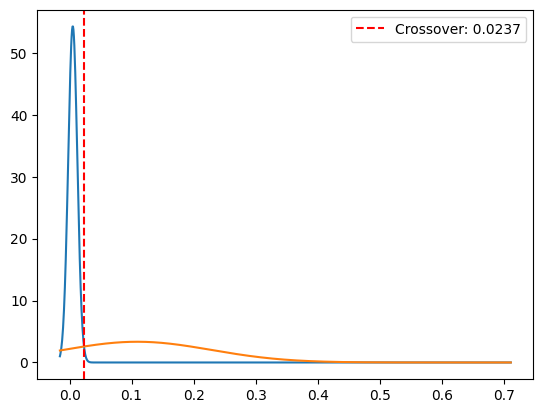

In [28]:
v1thresh=gmm_thresh(vexpl_vis,maskv1)

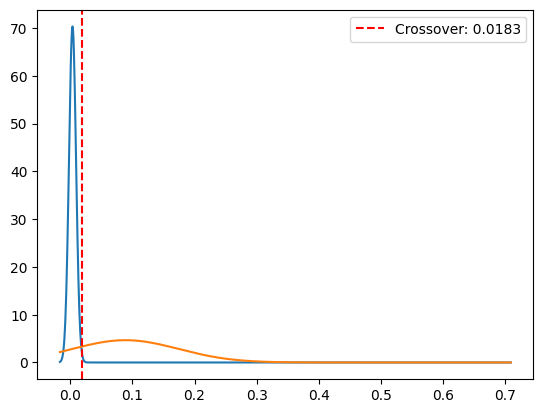

In [29]:
s1thresh=gmm_thresh(vexpl_som,masks1)

Define regions wherein both modalities are above threshold.

In [30]:
thresh_som=s1thresh[0]
thresh_vis=v1thresh[0] 
somthresh=vexpl_som>s1thresh
visthresh=vexpl_vis>v1thresh
both_true = np.logical_and(somthresh,visthresh)
sums=np.sum(both_true,axis=0)

Set up surfaces so as to define an adjacency matrix for clustering.

In [ ]:
nm=Subsurface('hcp_999999_draw_NH',[np.ones(vertsperhem).astype(bool),np.ones(vertsperhem).astype(bool)])
nm.get_surfaces()
adjL,adjR=nm.surfaces[0].adj,nm.surfaces[1].adj

In [ ]:

def brain_clusters_small(data, threshold, vertsperhem=vertsperhem):
    # Find clusters in the left and right hemisphere (assumes adjL and adjR are defined externally)
    clL = _find_clusters(data[:vertsperhem], threshold, adjacency=adjL)  # Returns (clusters_list, stats_list)
    clR = _find_clusters(data[vertsperhem:], threshold, adjacency=adjR)

    # Adjust right hemisphere clusters by adding vertsperhem to indices
    adjusted_clR_clusters = [c + vertsperhem for c in clR[0]]

    # Combine cluster stats and clusters from both hemispheres
    comb_stats = np.concatenate([clL[1], clR[1]])   # shape: (n_clusters_L + n_clusters_R,)
    comb_clusters = clL[0] + adjusted_clR_clusters  # a concatenation of two lists of arrays

    # Sort clusters by their corresponding stats in descending order
    # zip them, sort by stats, then unzip
    sorted_pairs = sorted(zip(comb_stats, comb_clusters), key=itemgetter(0), reverse=True)
    try:
        sorted_stats, sorted_clusters = map(list, zip(*sorted_pairs))
    except ValueError: 
        sorted_stats, sorted_clusters = [0], [0]

    return sorted_clusters, sorted_stats

Curtail to surface

In [31]:
somthresh_s,_=mch.decompose_data(somthresh.astype('float'))
visthresh_s,_=mch.decompose_data(visthresh.astype('float'))
both_true = np.logical_and(somthresh_s,visthresh_s)
sums=np.sum(both_true,axis=1)
sums=np.save(os.path.join(load_pkg_yaml()['paths']['plot_out'],'sums.npy'),sums)


Get the upper binomial limit for N=174

In [ ]:
n = 174
p = 0.5
alpha = 0.05/2

# Find the critical value where cumulative prob is just below 1 - alpha
crit = binom.ppf(1 - alpha, n, p)

Detect clusters wherein the N of joint tuning is above the upper binomial limit.

In [29]:
res=brain_clusters_small(sums,crit)

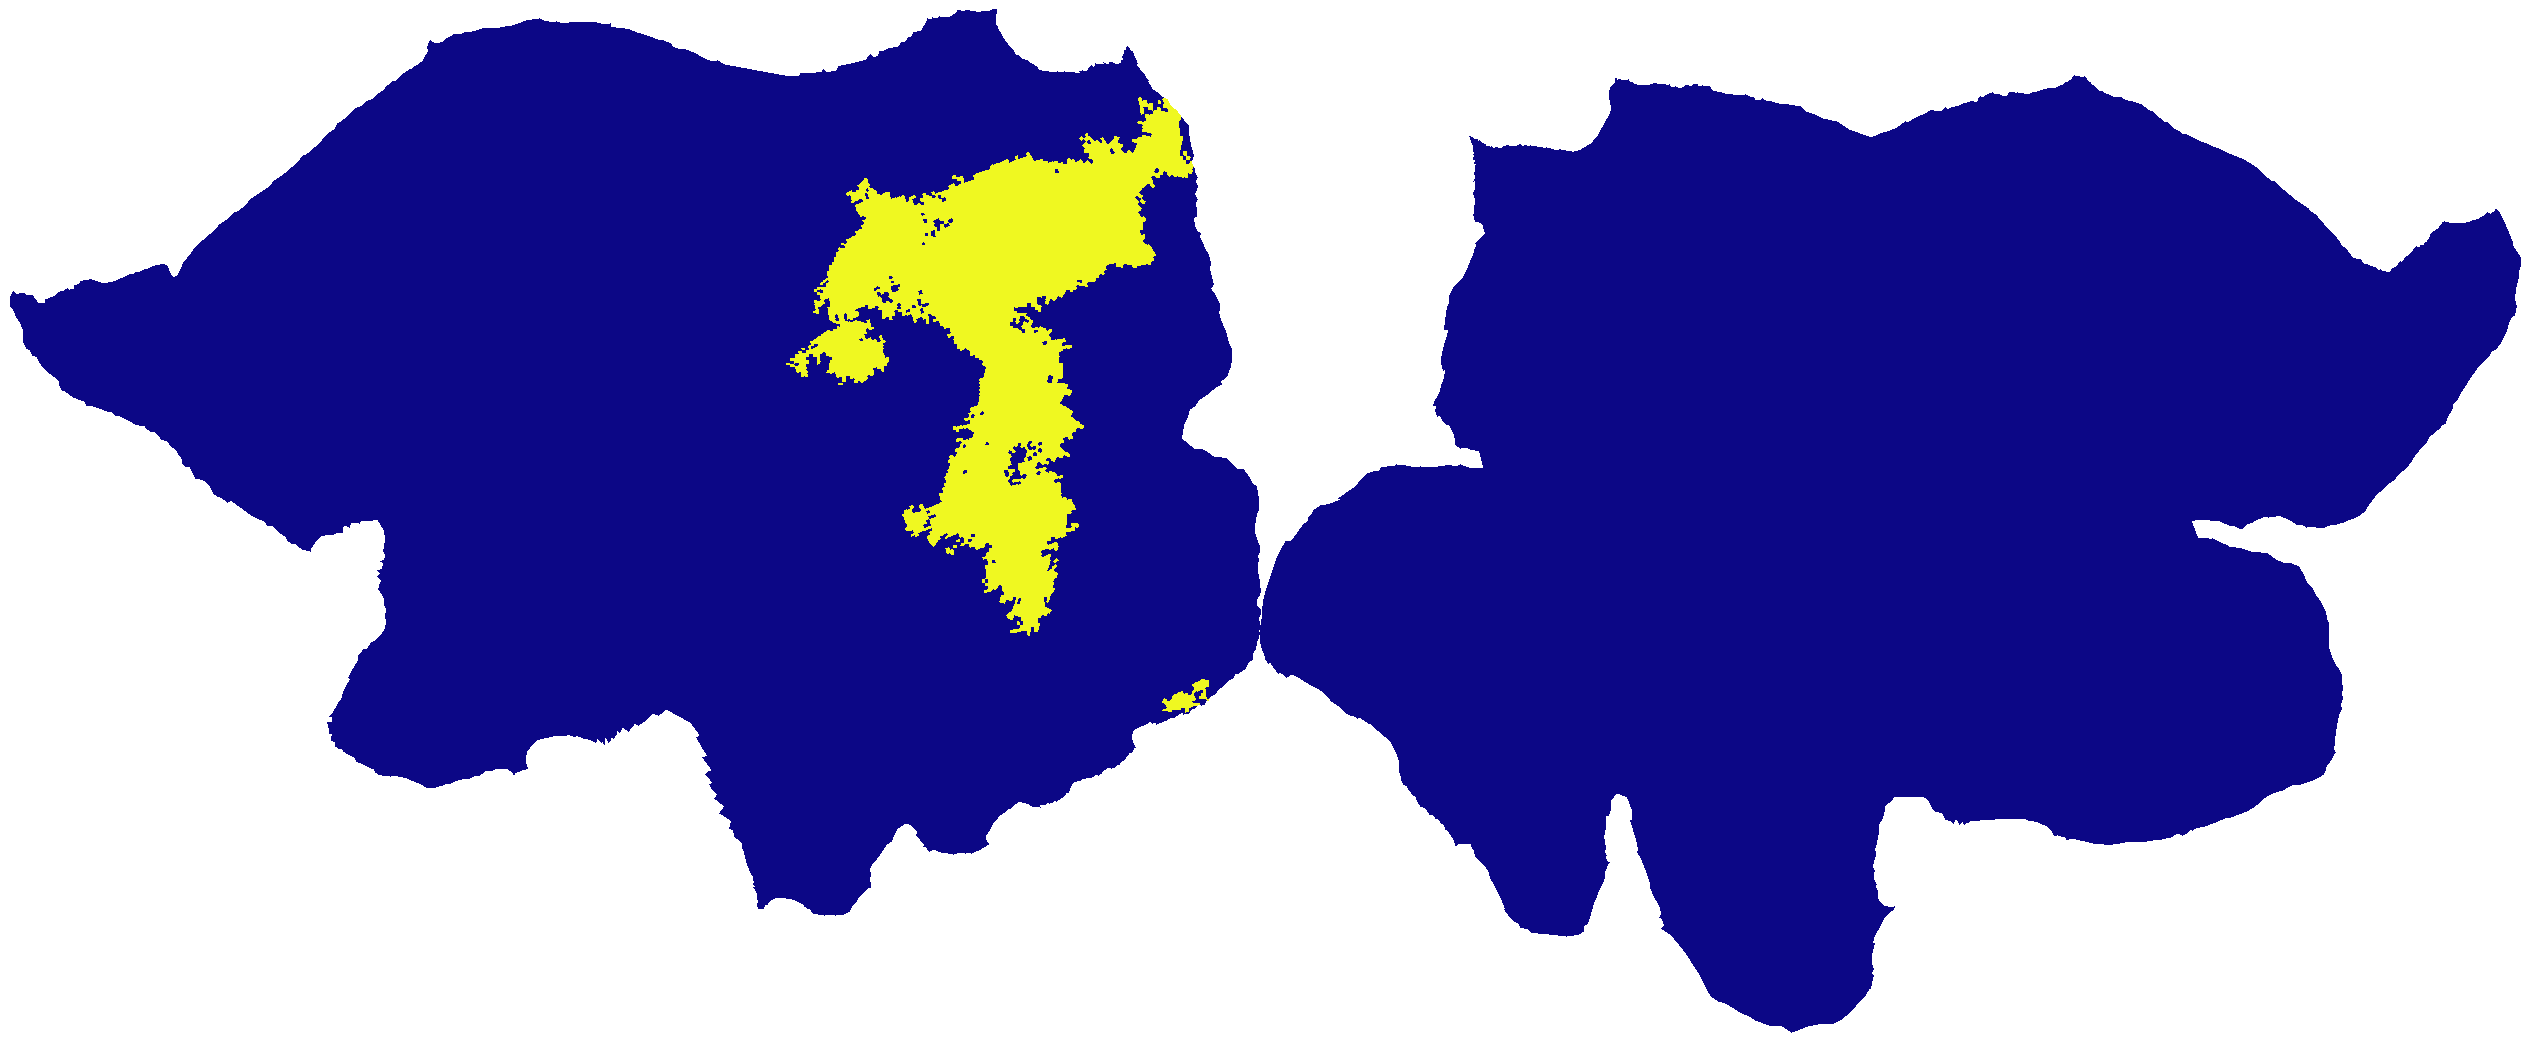

In [ ]:
empt=np.zeros(vertsperhem*2)
empt[res[0][1]]=1
bp=basic_plot(empt,vmax=1)

Make the laplacians on the surface for fitting a spatial model to the joint tuning data.

In [ ]:
nm.generate()
nm.make_laplacians(400)

Generating subsurfaces


Fit a trend surface model and permute the sign of the beta weights to get surrogate maps. Retain the largest cluster from each map.

In [ ]:
XL=nm.L_eigenvectors.real
YL=somthresh_s[:vertsperhem,:]
XR=nm.R_eigenvectors.real
YR=somthresh_s[:vertsperhem,:]
betaL, residuals, rank, s = np.linalg.lstsq(XL, YL, rcond=None)
betaR, residuals, rank, s = np.linalg.lstsq(XR, YR, rcond=None)


def permute_somthresh(vertsperhem=vertsperhem):
    rand_signsL = np.random.choice([-1, 1], size=betaL.shape)
    rand_signsR = np.random.choice([-1, 1], size=betaR.shape)
    yhatL=np.dot(XL, (betaL*rand_signsL))>np.mean(np.dot(XL, (betaL*rand_signsL)),axis=0)
    yhatR=np.dot(XR, (betaR*rand_signsR))>np.mean(np.dot(XR, (betaR*rand_signsR)),axis=0)
    yhat=np.concatenate([yhatL,yhatR],axis=0)

    both_true = np.logical_and(yhat,visthresh_s)
    sums=np.sum(both_true,axis=1)
    clust,stat=brain_clusters_small(sums, crit, vertsperhem=vertsperhem)

    return stat[0]


Permute X 1000.

In [ ]:
permutes=[permute_somthresh() for i in tqdm(range(1000))]
permarr=np.array(permutes)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [23:51<00:00,  1.43s/it]


Define significant clusters.

In [44]:
sig=res[1]>np.quantile(permarr,.975)

Display the clusters that meet the threshold

In [ ]:
clust=res[0]
empt=np.zeros(vertsperhem*2)
for i in range(np.where(sig)[0][-1]):
    empt[clust[i]]=i+1

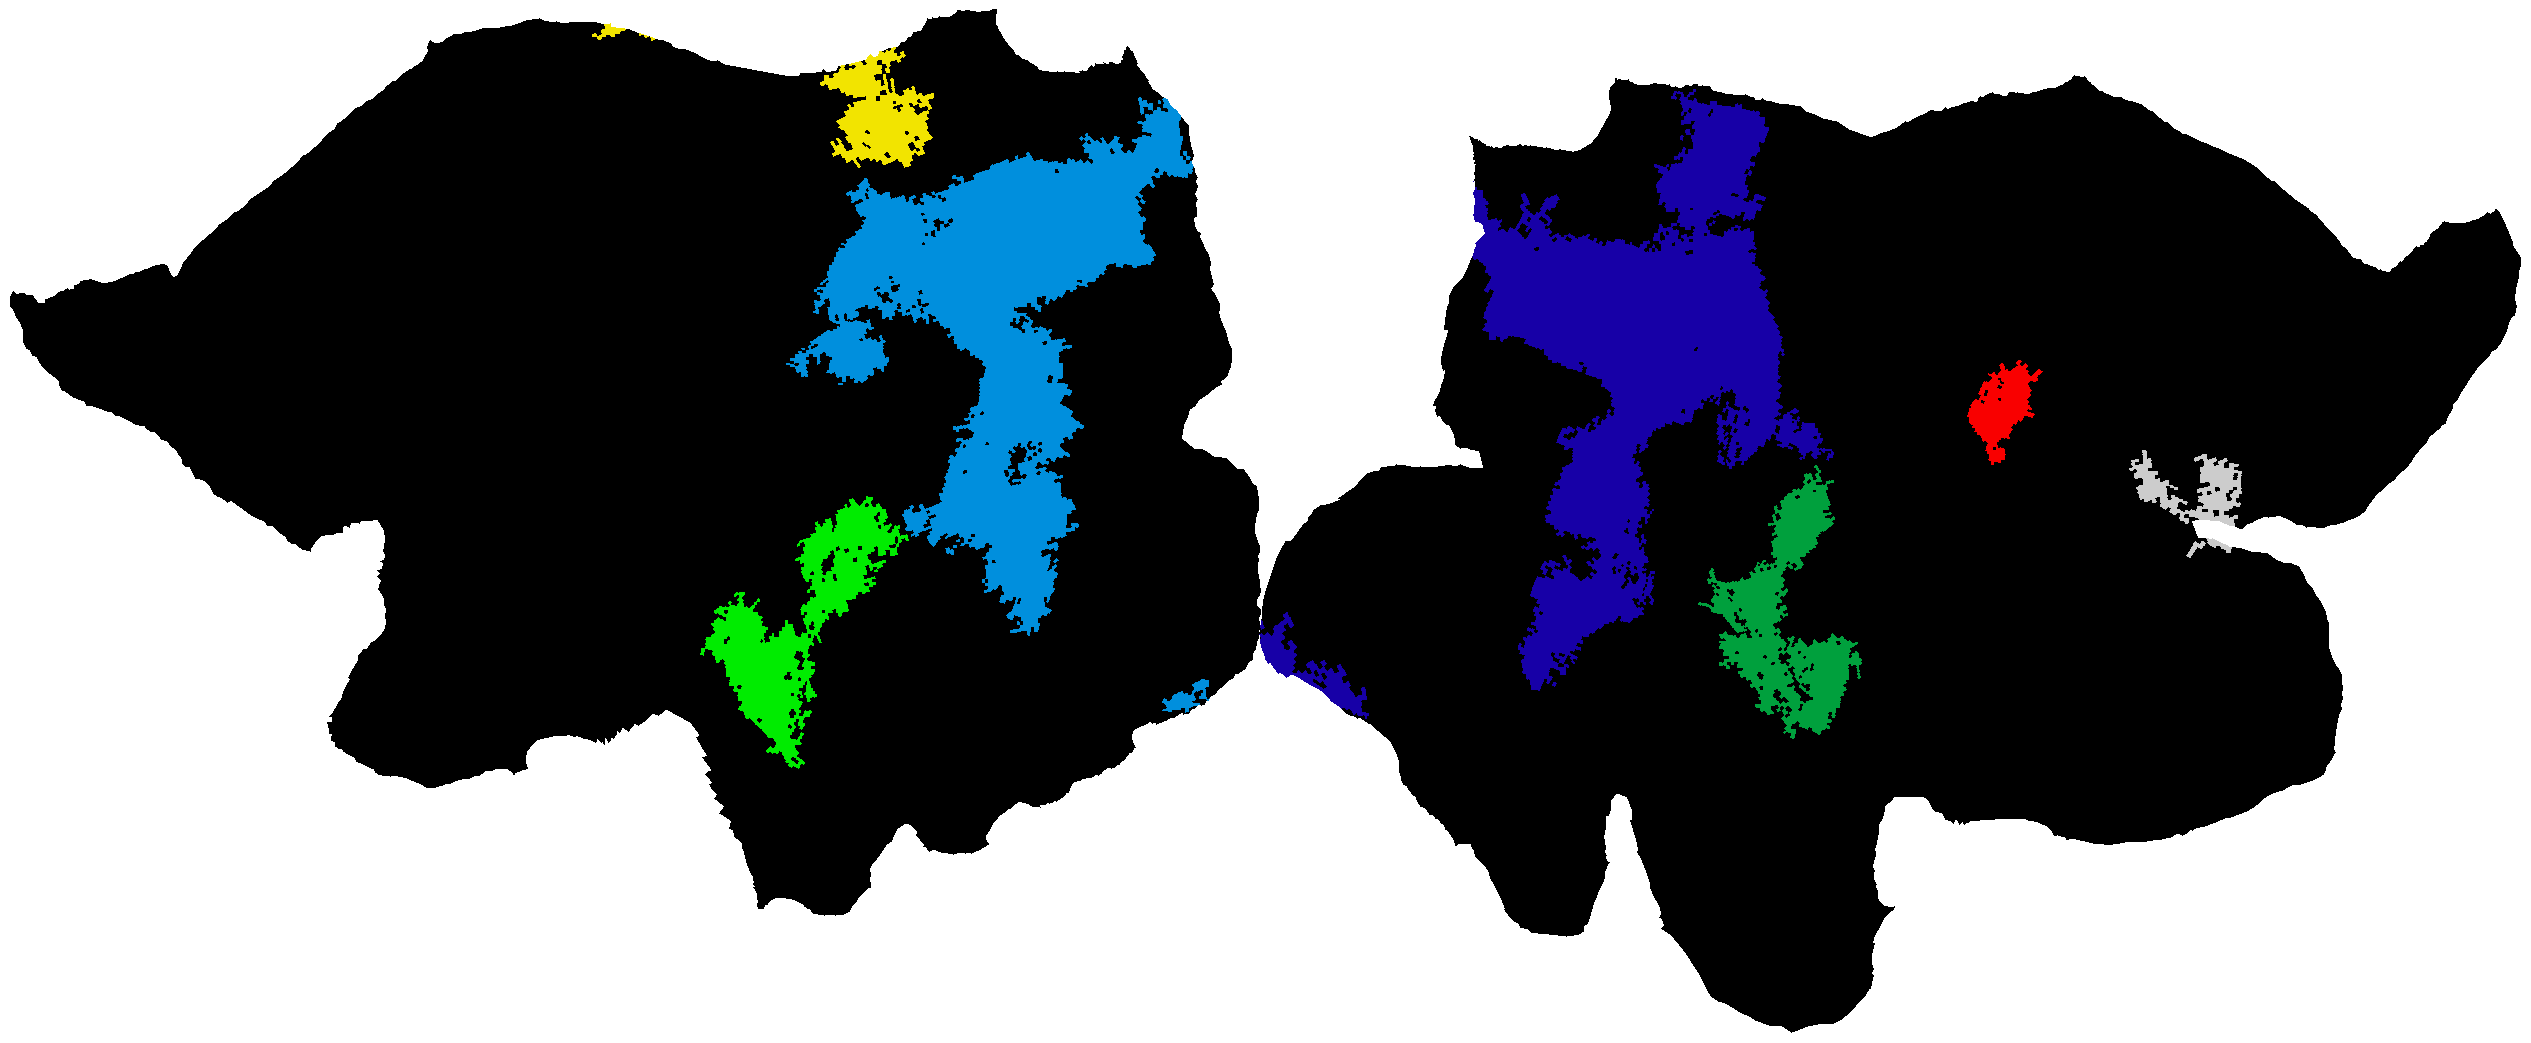

In [48]:
bp=basic_plot(empt,vmax=7,cmap='nipy_spectral')

In [61]:
np.array([np.sum(permarr>cluststat) for cluststat in res[1]])/1000

array([0.   , 0.   , 0.   , 0.   , 0.001, 0.001, 0.016, 0.019, 0.034,
       0.041, 0.092, 0.114, 0.143, 0.213, 0.217, 0.255, 0.297, 0.369,
       0.393, 0.422, 0.45 , 0.45 , 0.47 , 0.517, 0.522, 0.54 , 0.599,
       0.635, 0.67 , 0.67 , 0.689, 0.729, 0.771, 0.788, 0.788, 0.791,
       0.813, 0.813, 0.817, 0.823, 0.835, 0.835, 0.836, 0.836, 0.836,
       0.836, 0.837, 0.839, 0.843, 0.869, 0.869, 0.869, 0.871, 0.879,
       0.88 , 0.891, 0.891, 0.892, 0.897, 0.897, 0.9  , 0.9  , 0.9  ,
       0.913, 0.916, 0.918, 0.919, 0.925, 0.933, 0.94 , 0.94 , 0.94 ,
       0.94 , 0.94 , 0.941, 0.941, 0.941, 0.941, 0.944, 0.944, 0.944,
       0.946, 0.946, 0.946, 0.948, 0.948, 0.948, 0.952, 0.952, 0.952,
       0.952, 0.954, 0.954, 0.962, 0.962, 0.964, 0.964, 0.964, 0.964,
       0.964, 0.964, 0.965, 0.965, 0.965, 0.965, 0.965, 0.965, 0.965,
       0.965, 0.965, 0.965, 0.965, 0.965, 0.965, 0.966, 0.968, 0.968,
       0.968, 0.968, 0.968, 0.968, 0.968, 0.975, 0.975, 0.975, 0.975,
       0.975, 0.975,

Mask out the non-significant clusters and plot.

In [ ]:
sums=sums.astype(float)
sums[empt==0]=np.nan

adding rois
Unable to init server: Could not connect: Connection refused
** (inkscape:948122): WARNING **: 17:26:28.859: Fonts dir '/tank/hedger/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 2511 x 1024 pixels (96 dpi)
adding rois
Unable to init server: Could not connect: Connection refused
** (inkscape:948356): WARNING **: 17:26:30.252: Fonts dir '/tank/hedger/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 2511 x 1024 pixels (96 dpi)
adding rois
Unable to init server: Could not connect: Connection refused
** (inkscape:948454): WARNING **: 17:26:31.625: Fonts dir '/tank/hedger/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 2511 x 1024 pixels (96 dpi)
adding rois
Unable to init server: Could not connect: Connection refused
** (inkscape:948558): WARNING **: 17

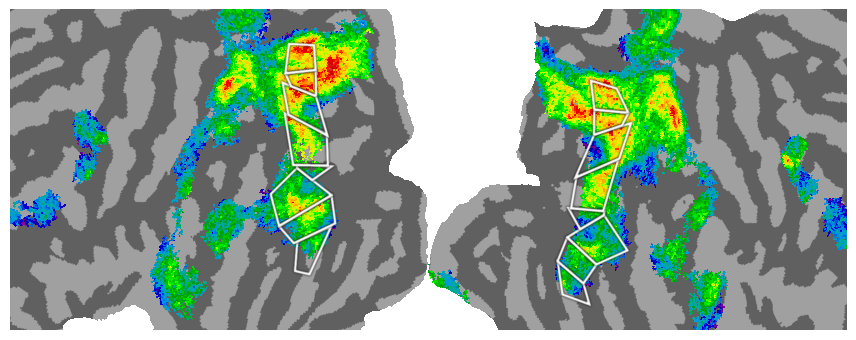

<Figure size 1800x900 with 0 Axes>

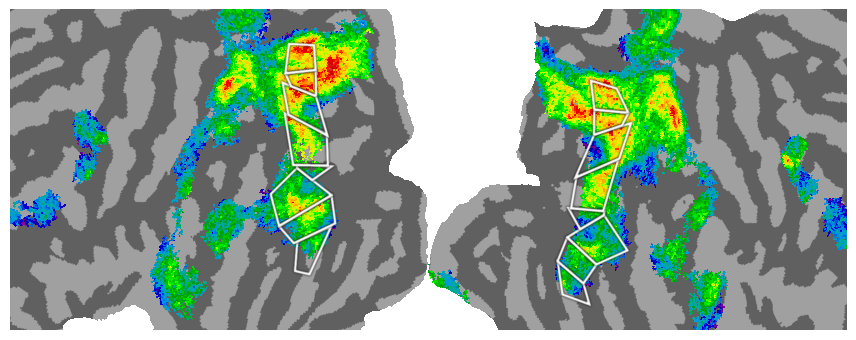

In [311]:
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['joint_subset_HCPthresh'])
mp.uber_plot(dat=sums,dat2=sums)